In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import lsqlin
from scipy import stats
import copy 
from sklearn import svm
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [2]:
vix_df = pd.read_excel( 'VIXfutures_20080414_20201231.xlsx' )

vix_df = vix_df.sort_values( by = ['Date'], ascending = True )

x_df = vix_df[ [ 'Date', 'VIX', 'w', \
                       'CMF30', 'CMF60', 'CMF90', 'CMF120', 'CMF150', \
                       'roll30', 'roll60', 'roll90', 'roll120', 'roll150', \
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9' ] ]

# for eache row, if it contains a non-number element in a column, then drop the entire row
x_df = x_df.dropna()

# for eache row, if it contains a 0 element in a column, then drop the entire row
#x_df = x_df.loc[ ( x_df != 0 ).all( axis = 1 ) ]

# reset the index
x_df= x_df.reset_index( drop = True )

dates = x_df[ 'Date' ]

In [3]:
vix = x_df.VIX 
T = len(vix)

v_1 = x_df.CMF30 
v_2 = x_df.CMF60 
v_3 = x_df.CMF90 
v_4 = x_df.CMF120 
v_5 = x_df.CMF150 

d_theta_log_v_1 = x_df.roll30 
d_theta_log_v_2 = x_df.roll60 
d_theta_log_v_3 = x_df.roll90 
d_theta_log_v_4 = x_df.roll120 
d_theta_log_v_5 = x_df.roll150 

In [4]:
vix_etn_number = 10
x_row = vix_etn_number + 1  #  plus 1 here is for the VIX
x_column = len( v_1 );
X = np.ones( ( x_row, x_column ) )

X[ 0, : ] =  np.log( vix )

X[ 1, : ] =  np.log( v_1 )
X[ 2, : ] =  np.log( v_2 )
X[ 3, : ] =  np.log( v_3 )
X[ 4, : ] =  np.log( v_4 )
X[ 5, : ] =  np.log( v_5 )

X[ 6, : ] = d_theta_log_v_1
X[ 7, : ] = d_theta_log_v_2
X[ 8, : ] = d_theta_log_v_3
X[ 9, : ] = d_theta_log_v_4
X[ 10, : ] = d_theta_log_v_5

In [5]:
#######################################################
####
#### 1-month and 5-month rolling futures portfolios
####
#######################################################

dt = 1/252;
r = .03
vxx = np.zeros(T)
vxz = np.zeros(T)
vxx[0]=100
vxz[0]=100
for t in range(T-1):
    vxx[t+1] = vxx[t]*(1+r*dt + X[ 6, t+1 ]*dt  + (X[ 1, t+1 ]-X[ 1, t ])/X[ 1, t ]  )
    vxz[t+1] = vxz[t]*(1+r*dt + X[ 10, t+1 ]*dt  + (X[ 5, t+1 ]-X[ 5, t ])/X[ 5, t ]  )
    
r_trade = -np.diff(vxx)/vxx[:-1] + 2*np.diff(vxz)/vxz[:-1] 

sign_trade = (np.sign(r_trade)+1)/2  ### sign of returns, to be predicted by classifier

In [6]:
#######################################################
####
#### divide data into training and testing
####
#######################################################

T_train = int(np.round(T/2))

ind_train = np.arange(0,T_train )
X_train = X[:,ind_train]
y_train = sign_trade[ind_train]

ind_test = np.arange(T_train ,T-1)
X_test = X[:,ind_test]
y_test = sign_trade[ind_test]

In [7]:
#######################################################
####
#### build and train deep neural network
####
#######################################################


relu_parameter = 0.1
neuron_num = 1000
activation_function = lambda x: tf.keras.activations.sigmoid( x )  # Sigmoid
#activation_function = lambda x: tf.keras.activations.relu( x, relu_parameter ) # Parameteric rectified linear unit
#activation_function = lambda x: tf.keras.activations.softplus( x )  # SoftPlus

model = tf.keras.Sequential( )
model.add( tf.keras.layers.Flatten( input_shape = ( 11, ) ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( 1, activation = 'sigmoid'  ) )

model.compile( loss = 'binary_crossentropy', optimizer = 'adam',\
              metrics = [ 'accuracy', 'mean_absolute_error' ] )



model_history = model.fit( X_train.T, y_train, \
                  epochs = 400, batch_size = 512, shuffle = True, validation_split = .2 )


Epoch 1/400
3/3 [==============================] - 0s 104ms/step - loss: 1.6914 - accuracy: 0.4742 - mean_absolute_error: 0.5336 - val_loss: 0.9045 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4915
Epoch 2/400
3/3 [==============================] - 0s 46ms/step - loss: 1.1191 - accuracy: 0.6086 - mean_absolute_error: 0.4184 - val_loss: 1.4279 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4876
Epoch 3/400
3/3 [==============================] - 0s 45ms/step - loss: 0.9684 - accuracy: 0.6086 - mean_absolute_error: 0.4173 - val_loss: 0.7053 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4974
Epoch 4/400
3/3 [==============================] - 0s 90ms/step - loss: 0.7166 - accuracy: 0.4602 - mean_absolute_error: 0.5043 - val_loss: 0.7391 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5038
Epoch 5/400
3/3 [==============================] - 0s 79ms/step - loss: 0.7674 - accuracy: 0.3914 - mean_absolute_error: 0.5237 - val_loss: 0.6928 - val_accuracy: 0.5140 - val_mean_ab

Epoch 41/400
3/3 [==============================] - 0s 52ms/step - loss: 0.6694 - accuracy: 0.6086 - mean_absolute_error: 0.4759 - val_loss: 0.7118 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4969
Epoch 42/400
3/3 [==============================] - 0s 47ms/step - loss: 0.6696 - accuracy: 0.6086 - mean_absolute_error: 0.4766 - val_loss: 0.7114 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4969
Epoch 43/400
3/3 [==============================] - 0s 47ms/step - loss: 0.6694 - accuracy: 0.6086 - mean_absolute_error: 0.4758 - val_loss: 0.7142 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4967
Epoch 44/400
3/3 [==============================] - 0s 46ms/step - loss: 0.6695 - accuracy: 0.6086 - mean_absolute_error: 0.4748 - val_loss: 0.7134 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4968
Epoch 45/400
3/3 [==============================] - 0s 48ms/step - loss: 0.6694 - accuracy: 0.6086 - mean_absolute_error: 0.4754 - val_loss: 0.7108 - val_accuracy: 0.5140 - val_mea

Epoch 81/400
3/3 [==============================] - 0s 48ms/step - loss: 0.6697 - accuracy: 0.6086 - mean_absolute_error: 0.4758 - val_loss: 0.7145 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4967
Epoch 82/400
3/3 [==============================] - 0s 45ms/step - loss: 0.6695 - accuracy: 0.6086 - mean_absolute_error: 0.4753 - val_loss: 0.7107 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4970
Epoch 83/400
3/3 [==============================] - 0s 47ms/step - loss: 0.6695 - accuracy: 0.6086 - mean_absolute_error: 0.4774 - val_loss: 0.7081 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4972
Epoch 84/400
3/3 [==============================] - 0s 49ms/step - loss: 0.6698 - accuracy: 0.6086 - mean_absolute_error: 0.4772 - val_loss: 0.7121 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4969
Epoch 85/400
3/3 [==============================] - 0s 47ms/step - loss: 0.6694 - accuracy: 0.6086 - mean_absolute_error: 0.4758 - val_loss: 0.7101 - val_accuracy: 0.5140 - val_mea

Epoch 121/400
3/3 [==============================] - 0s 47ms/step - loss: 0.6693 - accuracy: 0.6086 - mean_absolute_error: 0.4763 - val_loss: 0.7123 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4969
Epoch 122/400
3/3 [==============================] - 0s 90ms/step - loss: 0.6696 - accuracy: 0.6086 - mean_absolute_error: 0.4763 - val_loss: 0.7123 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4969
Epoch 123/400
3/3 [==============================] - 0s 47ms/step - loss: 0.6693 - accuracy: 0.6086 - mean_absolute_error: 0.4746 - val_loss: 0.7178 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4965
Epoch 124/400
3/3 [==============================] - 0s 63ms/step - loss: 0.6696 - accuracy: 0.6086 - mean_absolute_error: 0.4728 - val_loss: 0.7127 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4968
Epoch 125/400
3/3 [==============================] - 0s 59ms/step - loss: 0.6699 - accuracy: 0.6086 - mean_absolute_error: 0.4780 - val_loss: 0.7036 - val_accuracy: 0.5140 - va

Epoch 161/400
3/3 [==============================] - 0s 47ms/step - loss: 0.6362 - accuracy: 0.6539 - mean_absolute_error: 0.4564 - val_loss: 0.7069 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4896
Epoch 162/400
3/3 [==============================] - 0s 51ms/step - loss: 0.6279 - accuracy: 0.6461 - mean_absolute_error: 0.4401 - val_loss: 0.6925 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4942
Epoch 163/400
3/3 [==============================] - 0s 51ms/step - loss: 0.6281 - accuracy: 0.6570 - mean_absolute_error: 0.4400 - val_loss: 0.6876 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4909
Epoch 164/400
3/3 [==============================] - 0s 58ms/step - loss: 0.6200 - accuracy: 0.6672 - mean_absolute_error: 0.4400 - val_loss: 0.6939 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4884
Epoch 165/400
3/3 [==============================] - 0s 49ms/step - loss: 0.6191 - accuracy: 0.6680 - mean_absolute_error: 0.4253 - val_loss: 0.7036 - val_accuracy: 0.5078 - va

Epoch 201/400
3/3 [==============================] - 0s 48ms/step - loss: 0.6148 - accuracy: 0.6648 - mean_absolute_error: 0.4283 - val_loss: 0.6964 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4896
Epoch 202/400
3/3 [==============================] - 0s 51ms/step - loss: 0.6135 - accuracy: 0.6727 - mean_absolute_error: 0.4245 - val_loss: 0.6934 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4863
Epoch 203/400
3/3 [==============================] - 0s 98ms/step - loss: 0.6121 - accuracy: 0.6727 - mean_absolute_error: 0.4210 - val_loss: 0.6965 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4908
Epoch 204/400
3/3 [==============================] - 0s 66ms/step - loss: 0.6127 - accuracy: 0.6742 - mean_absolute_error: 0.4267 - val_loss: 0.6909 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4878
Epoch 205/400
3/3 [==============================] - 0s 79ms/step - loss: 0.6137 - accuracy: 0.6727 - mean_absolute_error: 0.4189 - val_loss: 0.6908 - val_accuracy: 0.5857 - va

Epoch 241/400
3/3 [==============================] - 0s 97ms/step - loss: 0.6179 - accuracy: 0.6687 - mean_absolute_error: 0.4189 - val_loss: 0.6976 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4857
Epoch 242/400
3/3 [==============================] - 0s 104ms/step - loss: 0.6165 - accuracy: 0.6680 - mean_absolute_error: 0.4242 - val_loss: 0.6981 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4895
Epoch 243/400
3/3 [==============================] - 0s 93ms/step - loss: 0.6117 - accuracy: 0.6781 - mean_absolute_error: 0.4263 - val_loss: 0.6961 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4859
Epoch 244/400
3/3 [==============================] - 0s 73ms/step - loss: 0.6158 - accuracy: 0.6664 - mean_absolute_error: 0.4175 - val_loss: 0.6924 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4874
Epoch 245/400
3/3 [==============================] - 0s 73ms/step - loss: 0.6165 - accuracy: 0.6727 - mean_absolute_error: 0.4288 - val_loss: 0.6949 - val_accuracy: 0.5732 - v

Epoch 281/400
3/3 [==============================] - 0s 62ms/step - loss: 0.6111 - accuracy: 0.6758 - mean_absolute_error: 0.4192 - val_loss: 0.6955 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4891
Epoch 282/400
3/3 [==============================] - 0s 62ms/step - loss: 0.6121 - accuracy: 0.6797 - mean_absolute_error: 0.4254 - val_loss: 0.6919 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4872
Epoch 283/400
3/3 [==============================] - 0s 59ms/step - loss: 0.6104 - accuracy: 0.6727 - mean_absolute_error: 0.4209 - val_loss: 0.6922 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4872
Epoch 284/400
3/3 [==============================] - 0s 52ms/step - loss: 0.6099 - accuracy: 0.6781 - mean_absolute_error: 0.4225 - val_loss: 0.6935 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4877
Epoch 285/400
3/3 [==============================] - 0s 56ms/step - loss: 0.6107 - accuracy: 0.6844 - mean_absolute_error: 0.4239 - val_loss: 0.6937 - val_accuracy: 0.5607 - va

Epoch 321/400
3/3 [==============================] - 0s 47ms/step - loss: 0.6098 - accuracy: 0.6711 - mean_absolute_error: 0.4186 - val_loss: 0.6936 - val_accuracy: 0.5826 - val_mean_absolute_error: 0.4881
Epoch 322/400
3/3 [==============================] - 0s 51ms/step - loss: 0.6114 - accuracy: 0.6812 - mean_absolute_error: 0.4249 - val_loss: 0.6919 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4874
Epoch 323/400
3/3 [==============================] - 0s 50ms/step - loss: 0.6097 - accuracy: 0.6805 - mean_absolute_error: 0.4196 - val_loss: 0.6947 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4861
Epoch 324/400
3/3 [==============================] - 0s 45ms/step - loss: 0.6124 - accuracy: 0.6695 - mean_absolute_error: 0.4169 - val_loss: 0.6941 - val_accuracy: 0.5826 - val_mean_absolute_error: 0.4876
Epoch 325/400
3/3 [==============================] - 0s 50ms/step - loss: 0.6124 - accuracy: 0.6812 - mean_absolute_error: 0.4255 - val_loss: 0.6945 - val_accuracy: 0.5794 - va

Epoch 361/400
3/3 [==============================] - 0s 108ms/step - loss: 0.6108 - accuracy: 0.6687 - mean_absolute_error: 0.4185 - val_loss: 0.6924 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4873
Epoch 362/400
3/3 [==============================] - 0s 92ms/step - loss: 0.6135 - accuracy: 0.6703 - mean_absolute_error: 0.4252 - val_loss: 0.6926 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4872
Epoch 363/400
3/3 [==============================] - 0s 126ms/step - loss: 0.6114 - accuracy: 0.6672 - mean_absolute_error: 0.4182 - val_loss: 0.6972 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4856
Epoch 364/400
3/3 [==============================] - 0s 111ms/step - loss: 0.6109 - accuracy: 0.6719 - mean_absolute_error: 0.4188 - val_loss: 0.6976 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4882
Epoch 365/400
3/3 [==============================] - 0s 94ms/step - loss: 0.6131 - accuracy: 0.6734 - mean_absolute_error: 0.4262 - val_loss: 0.6955 - val_accuracy: 0.5452 -

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


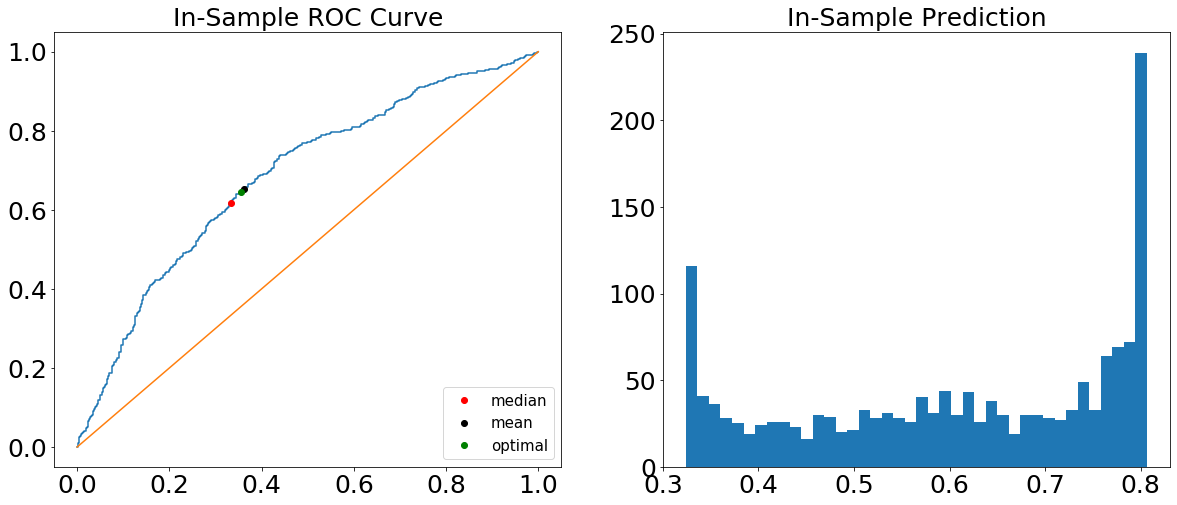

In [8]:
#######################################################
####
#### in-sample ROC curve to determine trading signal
####
#######################################################


y_score = model.predict(X_train.T).ravel()
fpr, tpr, threshold = roc_curve(y_train, y_score)

#### median, mean and optimal points on ROC curve
ind_med = np.argmin(np.abs(threshold-np.median(y_score)))
ind_mean = np.argmin(np.abs(threshold-np.mean(y_score)))
ind_opt = np.argmin(np.abs(tpr - (1-fpr) ))


fig, axs = plt.subplots( 1, 2, figsize = ( 20, 8 ) )
axs[0].plot(fpr,tpr)
axs[0].plot(fpr,fpr);
axs[ 0].tick_params( axis = 'both', which = 'major', labelsize = 25 )
axs[0].plot(fpr[ind_med],tpr[ind_med],'ro',label='median') 
axs[0].plot(fpr[ind_mean],tpr[ind_mean],'ko',label='mean'); 
axs[0].plot(fpr[ind_opt],tpr[ind_opt],'go',label='optimal'); 
axs[0].legend(loc="lower right",fontsize = 15)
axs[0].set_title('In-Sample ROC Curve',fontsize = 25);


axs[1].hist(y_score,40);
axs[1].set_title('In-Sample Prediction',fontsize = 25);
axs[1].tick_params( axis = 'both', which = 'major', labelsize = 25 )
plt.savefig( '../lecture18/NNROC_train_1000x4x400.eps', format = 'eps', bbox_inches = 'tight' )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


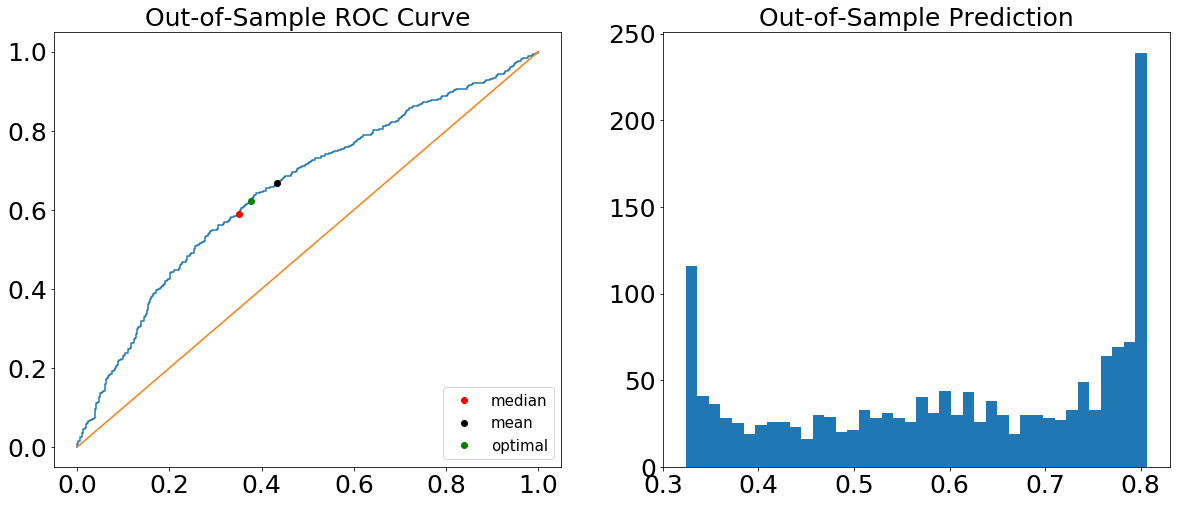

In [9]:
#######################################################
####
#### out-of-sample ROC curve
####
#######################################################


y_score_test = model.predict(X_test.T).ravel()
fpr, tpr, threshold = roc_curve(y_test, y_score_test)

#### median, mean and optimal points on ROC curve
ind_med = np.argmin(np.abs(threshold-np.median(y_score_test)))
ind_mean = np.argmin(np.abs(threshold-np.mean(y_score_test)))
ind_opt_test = np.argmin(np.abs(tpr - (1-fpr) ))


fig, axs = plt.subplots( 1, 2, figsize = ( 20, 8 ) )
axs[0].plot(fpr,tpr)
axs[0].plot(fpr,fpr);
axs[ 0].tick_params( axis = 'both', which = 'major', labelsize = 25 )
axs[0].plot(fpr[ind_med],tpr[ind_med],'ro',label='median') 
axs[0].plot(fpr[ind_mean],tpr[ind_mean],'ko',label='mean'); 
axs[0].plot(fpr[ind_opt_test],tpr[ind_opt_test],'go',label='optimal'); 
axs[0].legend(loc="lower right",fontsize = 15)
axs[0].set_title('Out-of-Sample ROC Curve',fontsize = 25);


axs[1].hist(y_score,40);
axs[1].set_title('Out-of-Sample Prediction',fontsize = 25);
axs[1].tick_params( axis = 'both', which = 'major', labelsize = 25 )
plt.savefig( '../lecture18/NNROC_test_1000x4x400.eps', format = 'eps', bbox_inches = 'tight' )

/usr/local/Cellar/jupyterlab/1.2.3/libexec/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


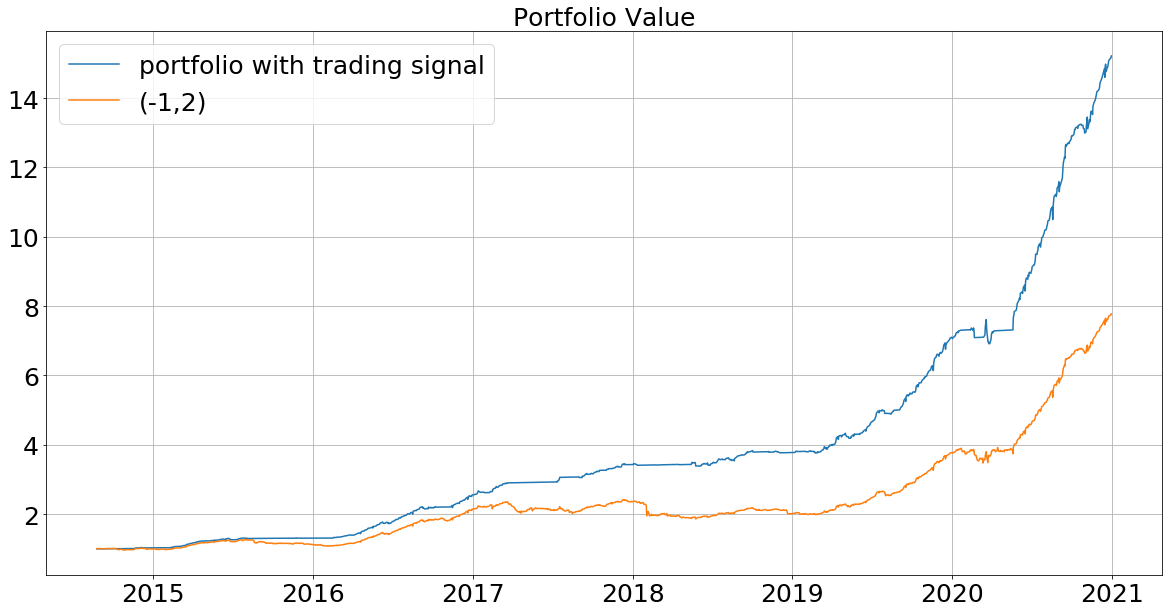

In [10]:
#######################################################
####
#### out-of-sample portfolio using trading signal
####
#######################################################

my_cutoff = threshold[ind_opt]   #### this is trading signal 

y_score = model.predict(X_test.T).ravel()
my_predict = (np.sign(y_score-my_cutoff)+1)/2

r_my_trade = my_predict*(r_trade[ind_test]) +(1-my_predict)*r*dt
p_my_trade = np.exp(np.cumsum(np.log(1+r_my_trade)))
p_trade = np.exp(np.cumsum(np.log(1+r_trade[ind_test])))


plt.figure( figsize = ( 20, 10 ) )
plt.plot(dates[ind_test],p_my_trade, label="portfolio with trading signal");
plt.plot(dates[ind_test],p_trade, label="(-1,2)");
plt.title('Portfolio Value', fontsize = 25 )
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.legend(loc="upper left",fontsize = 25)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture18/NNSignal1000x4x400.eps', format = 'eps', bbox_inches = 'tight' );



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


my return rate:  0.428785220735899
(-1,2) return rate:  0.323084094815226


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


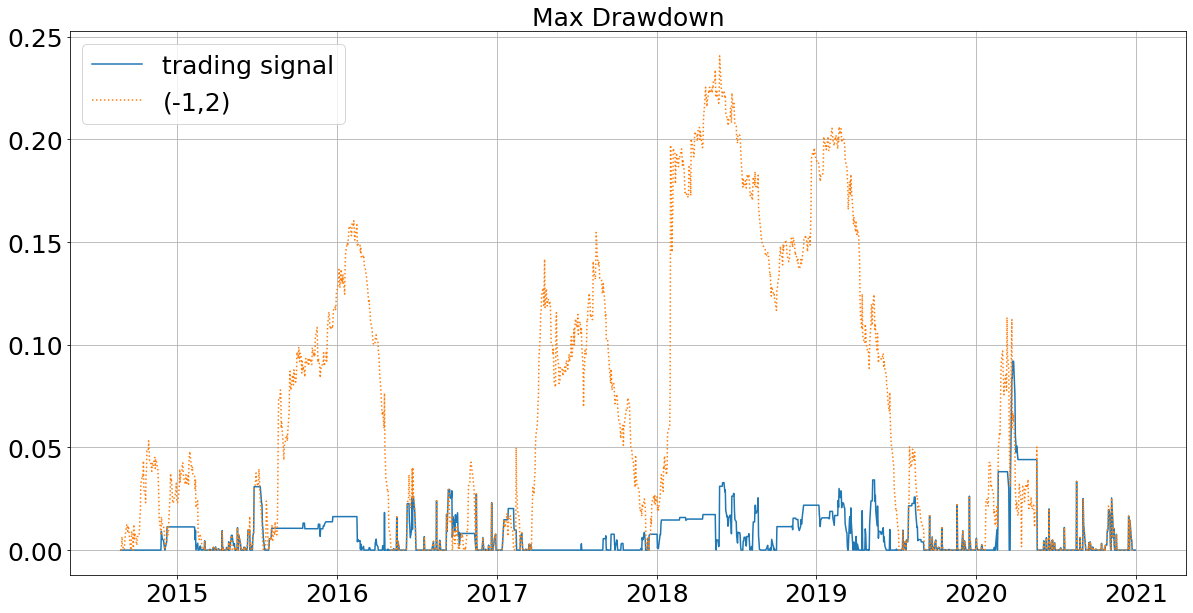

In [14]:
#######################################################
####
#### out-of-sample portfolio return rates and max drawdowns
####
#######################################################

print('my return rate: ',np.log(p_my_trade[-1])/(len(ind_test)*dt))
print('(-1,2) return rate: ',np.log(p_trade[-1])/(len(ind_test)*dt))

p_my_trade_discount = p_my_trade*np.exp(-r*dt*np.arange(len(ind_test)))
p_trade_discount = p_trade*np.exp(-r*dt*np.arange(len(ind_test)))
                                        
my_dd = 1-p_my_trade_discount/np.maximum.accumulate(p_my_trade_discount)
dd = 1-p_trade_discount/np.maximum.accumulate(p_trade_discount)

plt.figure( figsize = ( 20, 10 ) )
plt.plot(dates[ind_test],my_dd,label="trading signal")
plt.plot(dates[ind_test],dd,':',label="(-1,2)");
plt.title('Max Drawdown', fontsize = 25);
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.legend(loc="upper left",fontsize = 25)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture18/NNSignal1000x4x400_maxDD.eps', format = 'eps', bbox_inches = 'tight' );



In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 1000)              12000     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1001      
Total params: 3,016,001
Trainable params: 3,016,001
Non-trainable params: 0
______________________________________________

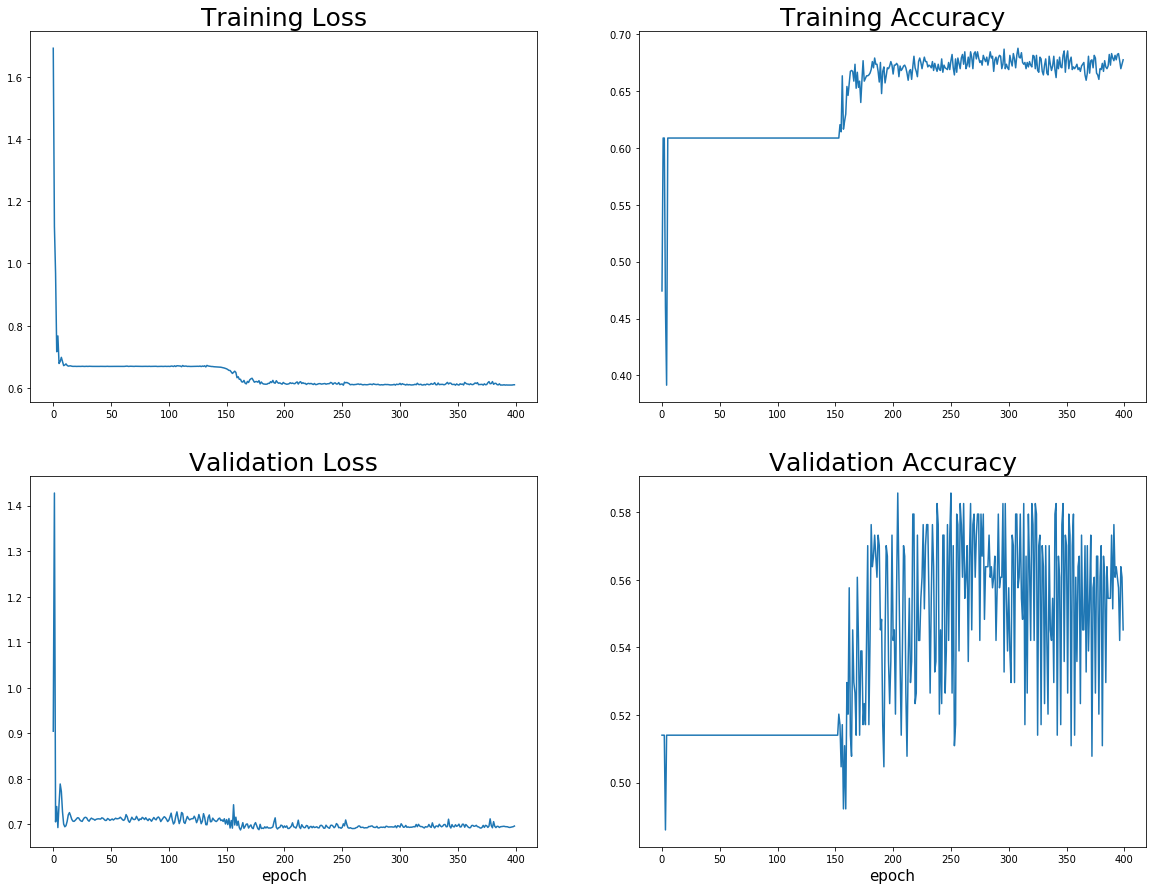

In [13]:
fig, axs = plt.subplots( 2, 2, figsize = ( 20, 15 ) )
axs[0,0].plot(model_history.history['loss'])
axs[0,0].set_title('Training Loss',fontsize = 25);

axs[0,1].plot(model_history.history['accuracy'])
axs[0,1].set_title('Training Accuracy',fontsize = 25);

axs[1,0].plot(model_history.history['val_loss'])
axs[1,0].set_title('Validation Loss',fontsize = 25);
axs[1,0].set_xlabel('epoch',fontsize = 15)

axs[1,1].plot(model_history.history['val_accuracy'])
axs[1,1].set_title('Validation Accuracy',fontsize = 25);
axs[1,1].set_xlabel('epoch',fontsize = 15);

plt.savefig( '../lecture18/NNSignal1000x4x400_diagnostics.eps', format = 'eps', bbox_inches = 'tight' );

